## CV12 - 직접 만들어보는 OCR

텍스트 detection은 Keras-OCR를 이용하고 recognition은 직접 만들어보기  
keras-ocr : https://github.com/faustomorales/keras-ocr  
craft : https://arxiv.org/pdf/1904.01941.pdf  
https://github.com/notAI-tech/keras-craft  
모델의 발전사 : https://arxiv.org/pdf/1904.01906.pdf  
### Dataset for OCR
Recognition model의 정량적인 평가를 위해 MJ Synth, SynthText 데이터셋을 활용한다.  
http://www.robots.ox.ac.uk/~vgg/data/text/   
http://www.robots.ox.ac.uk/~vgg/data/scenetext/  
MJ데이터  
https://drive.google.com/drive/folders/1xYcMdOMdP4N738hBTg6Pg-40vWf6jJz4

In [1]:
# mkdir -p ~/aiffel/ocr
# cd ~/aiffel/ocr

import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

### Recognition model
CRNN 구조를 활용해서 만들어보기  
https://arxiv.org/pdf/1507.05717.pdf  
이미지를 conv를 통해 feature맵 추출하고 recurrent layer에서 전체적인 context을 파악하고 다양한 output의 크기에 대응 가능  
transcription layer은 step마다 어떤 character의 확률이 높은지 예측한다.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
# pip install lmdb

In [5]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

### 1) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


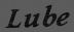

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


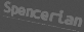

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


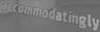

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


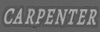

In [6]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

이미지의 높이는 31, 32이고, 너비는 문자열 길이에 따라 다양하다.

In [7]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        # Return image array and label in string
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

이미지 데이터를 img, label의 쌍으로 가져온다. 
### 3) Encode
각 character들이 어떤 index와 매핑되어 저장된다. 모델이 학습할 수 있게

In [8]:
class LabelConverter(object):
    
     """ Convert between text-label and text-index """

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [9]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 4) Build CRNN model
K.ctc_batch_cost()를 활용해서 loss계산하는 함수

In [10]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

input과 lable의 길이가 다르다.  
input이 AAAPPPPLLLLEE이고 label이 APPLE일 경우가 있다.  
text recognition과 유사한 경우다.  
K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
y_ture: 실제 라벨, 핫인코딩된 형태, max_string_length=22  
y_pred: RCNN모델의 출력 결과, 24  
input_length: 모델 입력 길이 T, 이미지 width
label_length: 실제 정답 길이

In [12]:
# image_input을 입력하고 label를 output으로 출력하는 함수

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

### 5) Train & Inference

In [ ]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

In [ ]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)